# Novelty Analysis

## Comparing Novelty Algorithms to SemDis 
## Comparing Novelty Algorithms to Human Raters

### Import Packages

In [58]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from functools import reduce
import openpyxl
import xlsxwriter

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk import ngrams, FreqDist
from nltk.lm import NgramCounter
import string
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from spacy.lang.en.stop_words import STOP_WORDS

from collections import Counter
import itertools

from sklearn.metrics.pairwise import cosine_similarity

from scipy import spatial

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

from nltk.cluster.kmeans import KMeansClusterer

from scipy import stats
from scipy.stats import pearsonr

import pingouin as pg

### Put Data from Excel Sheet into Dataframes

In [2]:
# individual df's for each sheet

# when on pc
data_official_cup = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_cup_semdis.csv")
data_official_key = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_key_semdis.csv")
data_official_rope = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_rope_semdis.csv")
data_official_brick = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_brick_semdis.csv")
data_official_chair = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_chair_semdis.csv")
data_official_pencil = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_pencil_semdis.csv")
data_official_shoe = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_shoe_semdis.csv")
data_official_box = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_box_semdis.csv")

# when on mac
# data_official_cup = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_cup_semdis.csv.xlsx")
# data_official_key = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_key_semdis.csv.xlsx")
# data_official_rope = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_rope_semdis.csv.xlsx")
# data_official_brick = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_brick_semdis.csv.xlsx")
# data_official_chair = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_chair_semdis.csv.xlsx")
# data_official_pencil = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_pencil_semdis.csv.xlsx")
# data_official_shoe = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_shoe_semdis.csv.xlsx")
# data_official_box = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/official/semdis/autdata_official_box_semdis.csv.xlsx")

### Preprocessing

In [3]:
# nltk corpus stop words
stopwords_nltk = stopwords.words('english')
# spacy stop words
stopwords_spacy = STOP_WORDS

In [4]:
stopwords_edited = list(stopwords_spacy)
stopwords_edited.append("thing")
stopwords_edited.append("use")
stopwords_edited.append("things")

In [5]:
# method to clean the responses
def process_text(text, stopwords_list, remove_sw, join_list):
    # tokenize text, lemmanize words, removing punctuation, remove stop words, lowercase all words

    # hardcorded for special situations
    text = re.sub(r"doorstoppper","doorstop", text)
    
    text = re.sub("/|-"," ", text)
    text = text.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)

    tokens = [w.lower() for w in tokens]
    
    if remove_sw:
        tokens = [word for word in tokens if word not in stopwords_list]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
#         stemmer = PorterStemmer()
#         tokens = [stemmer.stem(t) for t in tokens]

    if join_list:
        tokens = ' '.join(tokens)
 
    return tokens

### General Functions

In [6]:
# method to get a list of participants
def get_id_list(df):
    id_list = df['id'].unique()
    id_list = sorted(id_list)
    return id_list

In [7]:
# method to add a new column
# new column are cleaned responses
def get_cleaned_responses(df, stopwords_list, remove_sw, join_list):
    # id_df = df[df.id == id]
    df_processed = df.copy(deep=True)
    responses = df['response'].tolist()

    # make list of processed responses
    for response in range(len(responses)):
        responses[response] = process_text(responses[response], stopwords_list, remove_sw, join_list)

    # add list as column in df
    df_processed['response_processed'] = responses

    return df_processed

## Semantic Spaces


### ukwac subtitles Semantic Space

In [8]:
# when on pc
ukwac_subtitles = pd.read_csv('C:/Users/jhec8/Documents/Northwestern_SROP/cbow_6_ukwac_subtitle.txt', delimiter = " ", header = None)

# when on mac
# ukwac_subtitles_sem_space = pd.read_csv('/Users/johnhenrycruz/Desktop/Northwestern_SROP/cbow_6_ukwac_subtitle.txt', delimiter = " ", header = None, encoding='latin-1')

ukwac_subtitles = ukwac_subtitles.set_index(0)


In [9]:
ukwac_subtitles

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
biennials,0.018570,-0.115743,0.052710,-0.103825,-0.003274,-0.111418,-0.178500,-0.168650,-0.059751,-0.139651,...,0.121335,-0.021174,-0.113822,-0.110219,0.002543,-0.079831,0.103625,0.188465,0.117148,0.035641
fawn,0.071241,0.080455,0.216394,-0.282252,-0.172025,-0.186543,0.040009,0.044497,-0.045530,-0.079626,...,0.134902,-0.007096,-0.046929,0.022484,-0.042331,0.082441,0.077913,0.417162,-0.313959,-0.040423
gai,-0.183570,-0.039461,0.036953,-0.330616,-0.290676,0.095041,0.187567,0.019878,-0.115750,0.078831,...,0.042250,-0.009011,-0.311596,-0.131843,0.078453,0.048432,-0.005434,-0.001165,-0.072534,-0.151484
nunnery,-0.037334,0.180116,0.046011,-0.454054,-0.102627,-0.037614,-0.081269,-0.144102,0.018661,-0.312565,...,0.099364,-0.011798,-0.315447,0.160066,-0.179072,0.085825,-0.018394,0.055811,0.460388,0.107053
icici,0.010815,-0.050479,0.164478,-0.035702,-0.192204,0.003913,-0.063542,-0.095691,-0.131409,-0.090370,...,-0.040970,-0.021843,-0.071962,-0.120538,-0.018662,-0.263689,-0.119164,-0.013069,0.030275,-0.072135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
proteasome,0.065590,0.063595,-0.068297,-0.341265,-0.363577,-0.028856,0.121471,-0.163342,0.164599,-0.033824,...,0.092268,-0.019238,0.032392,0.024969,0.011309,0.061474,0.066890,-0.148575,-0.067886,0.027040
jawbone,-0.198237,-0.221238,0.034535,-0.125550,0.261507,-0.176464,0.154252,-0.001421,-0.012786,0.101746,...,0.173170,-0.018633,-0.150698,-0.278048,-0.083264,-0.138730,0.011749,0.292462,-0.002925,0.116922
expands,-0.204973,-0.104741,0.371615,-0.127140,-0.024127,-0.217444,-0.088636,0.147861,-0.060367,-0.200520,...,0.093103,0.040245,-0.231791,-0.101625,0.162721,-0.040362,0.097418,-0.007231,0.107961,-0.058140


### CBOW subtitles Semantic Space

In [10]:
# when on pc
cbow_subtitles = pd.read_csv('C:/Users/jhec8/Documents/Northwestern_SROP/cbow_subtitle.txt', delimiter = " ", header = None)

# when on mac
# ukwac_subtitles_sem_space = pd.read_csv('/Users/johnhenrycruz/Desktop/Northwestern_SROP/cbow_subtitle.txt', delimiter = " ", header = None, encoding='latin-1')

cbow_subtitles = cbow_subtitles.set_index(0)


In [11]:
cbow_subtitles

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
fawn,-0.092878,0.096702,0.078285,0.141875,-0.048455,0.022562,-0.116627,-0.133138,-0.006373,0.065410,...,-0.141192,0.033917,-0.091994,-0.198885,0.086601,-0.084499,0.128204,0.130868,0.034637,-0.011805
gai,-0.073987,-0.135876,0.071925,0.050427,-0.117428,0.119181,0.000579,0.058539,-0.164071,-0.039671,...,0.011994,0.046088,0.127052,0.037256,-0.099584,-0.093139,-0.116162,0.049216,-0.186436,0.006694
impotents,-0.002924,-0.016872,0.020181,0.015595,-0.016781,-0.014786,-0.007104,-0.016849,-0.026617,0.000086,...,0.045714,-0.037038,0.003953,-0.012306,0.007597,0.014559,-0.013585,-0.008614,0.016856,0.032169
sonja,0.046202,0.124720,0.111161,0.241513,-0.163221,0.119522,-0.011830,0.045682,0.213233,0.141021,...,-0.117941,0.133043,-0.038438,-0.089926,0.061131,-0.143988,-0.058695,0.110329,-0.069613,-0.142646
dionysian,0.032223,-0.007911,-0.008691,-0.015038,-0.037716,0.028007,-0.026402,0.023947,-0.036913,0.033985,...,-0.022568,-0.009473,0.001342,-0.056279,-0.001985,-0.037703,-0.027222,0.015461,-0.016171,0.015194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jawbone,-0.155908,-0.022339,0.029578,0.061183,-0.016605,-0.026134,0.004525,0.002993,-0.120240,0.077789,...,0.005585,-0.052877,0.068886,-0.118713,-0.161840,0.027309,-0.031582,0.072750,-0.000247,-0.041733
bunches,-0.032415,0.140536,0.071025,0.022989,0.031107,0.122717,-0.029894,0.092296,-0.071899,-0.097607,...,-0.010892,-0.053674,-0.071419,-0.081352,-0.032544,-0.096401,-0.006610,0.108215,0.034687,0.185569
zinka,-0.006705,0.002355,0.012616,0.021504,-0.002360,0.017963,-0.008720,-0.000567,-0.014686,-0.000533,...,-0.003436,0.006517,-0.006647,-0.009388,0.003580,-0.006105,0.006303,0.012804,0.005335,0.014729


### Banori Semantic Space

In [12]:
# when on pc
banori = pd.read_csv('C:/Users/jhec8/Documents/Northwestern_SROP/banori.txt', delimiter = " ", header = None)

# when on mac
# ukwac_subtitles_sem_space = pd.read_csv('/Users/johnhenrycruz/Desktop/Northwestern_SROP/banori.txt', delimiter = " ", header = None, encoding='latin-1')

banori = banori.set_index(0)

In [13]:
banori

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
0,,,,,,,,,,,,,,,,,,,,,
the,-0.060292,0.067630,-0.036891,0.066684,0.024045,0.099091,0.009682,-0.099609,0.081138,-0.153635,...,0.011333,-0.072486,-0.116943,0.071367,0.002056,0.041920,0.017046,0.038706,0.033797,0.016488
",",0.026625,0.073101,-0.027073,-0.019504,0.041730,0.038811,0.094878,-0.031282,0.093890,-0.105021,...,-0.002796,0.029393,-0.069047,0.083530,-0.033128,-0.035646,0.027183,0.003230,0.000811,0.022505
.,-0.005893,0.093791,0.015333,0.046226,0.032791,0.110069,0.055551,-0.080625,0.150372,-0.121523,...,0.076293,-0.048817,-0.203812,0.012218,0.039033,-0.043925,0.087199,0.089214,0.073069,0.075056
of,-0.050371,0.031452,0.040910,0.033255,-0.009195,0.061086,0.085859,-0.122968,0.068290,-0.108840,...,-0.021496,-0.112018,-0.116068,0.071437,-0.041942,0.061624,0.030890,0.013635,-0.104569,0.005263
and,0.005456,0.063237,-0.075793,-0.000819,0.003407,0.053554,0.070145,-0.088482,0.129797,-0.094823,...,0.100012,-0.090594,-0.090813,0.028959,0.024793,-0.040878,-0.024795,0.083654,-0.010910,0.027067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scientifica,-0.121726,0.094667,0.025527,0.001748,0.087804,-0.004830,-0.011430,-0.068062,0.016917,0.031084,...,0.082360,-0.025217,0.008511,-0.109005,-0.034504,0.027565,0.115459,0.000142,-0.022383,0.042615
schoolly,0.015603,0.100056,-0.042075,-0.032139,0.024201,0.051871,-0.069512,-0.144775,0.110104,-0.106074,...,0.014019,-0.040083,0.088833,-0.015218,-0.063183,0.021593,-0.101472,0.023395,0.022891,0.036009
schnapf,-0.057437,0.181676,-0.063820,0.017294,0.002916,0.019541,0.080525,-0.054740,-0.071306,-0.007485,...,0.079774,-0.068784,0.087408,-0.044859,-0.046738,-0.022576,0.023053,0.026027,0.010763,0.063920


### GloVe 6B Semantic Space

In [14]:
# when on pc
glove_6B = pd.read_csv('C:/Users/jhec8/Documents/Northwestern_SROP/glove_6B.txt', delimiter = " ", header = None)

# when on mac
# ukwac_subtitles_sem_space = pd.read_csv('/Users/johnhenrycruz/Desktop/Northwestern_SROP/glove_6B.txt', delimiter = " ", header = None, encoding='latin-1')

glove_6B = glove_6B.set_index(0)


In [15]:
glove_6B

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.641300,...,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.385400,...,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.678500,...,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.572100,...,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.847700,...,-0.012806,-0.597070,0.317340,-0.252670,0.543840,0.063007,-0.049795,-0.160430,0.046744,-0.070621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chanty,0.392700,-0.022505,0.304580,0.187990,0.141180,0.724030,-0.257810,-0.137290,-0.016521,0.595960,...,-0.182950,0.406630,-0.343630,-0.270400,-0.593680,0.016447,0.140740,0.463940,-0.369570,-0.287180
kronik,0.136790,-0.139090,-0.360890,0.079864,0.321490,0.263870,-0.109900,0.044420,0.083869,0.791330,...,0.036419,-0.036845,-0.348150,0.064732,-0.000577,-0.133790,0.428960,-0.023320,0.410210,-0.393080
rolonda,0.075713,-0.040502,0.183450,0.512300,-0.228560,0.839110,0.178780,-0.713010,0.326900,0.695350,...,-0.388530,0.545850,-0.035050,-0.184360,-0.197000,-0.350030,0.160650,0.218380,0.309670,0.437610


### TASA Semantic Space

In [16]:
# when on pc
TASA = pd.read_csv('C:/Users/jhec8/Documents/Northwestern_SROP/TASA.txt', delimiter = " ", header = None)

# when on mac
# ukwac_subtitles_sem_space = pd.read_csv('/Users/johnhenrycruz/Desktop/Northwestern_SROP/TASA.txt', delimiter = " ", header = None, encoding='latin-1')

TASA = TASA.set_index(0)


In [17]:
TASA

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
who,0.058924,-0.003555,0.053929,0.037707,-0.028096,-0.025736,0.008540,-0.041124,-0.000275,0.002969,...,0.002788,-0.005665,0.008141,0.035108,-0.005556,0.001101,0.022807,-0.001179,-0.004761,0.000947
were,0.076660,0.007832,0.102716,-0.046048,0.006808,-0.012557,0.012856,-0.043569,0.004773,0.027316,...,0.000811,0.003786,-0.011847,0.010002,0.027371,0.010266,-0.000217,0.005904,-0.005155,-0.017014
the,0.037283,-0.011585,0.003933,-0.006798,0.012415,0.000927,0.004378,-0.003837,0.006263,-0.002052,...,0.000049,0.000939,-0.001295,0.000544,0.000071,-0.000817,0.001123,-0.000980,-0.000354,0.000634
first,0.049274,-0.012220,0.023342,0.002829,0.008936,0.004214,0.041426,-0.014812,0.020341,0.018361,...,0.027615,0.016552,0.052426,-0.001099,-0.024695,-0.008158,-0.026864,-0.000865,-0.030933,-0.035347
americans,0.017895,-0.024743,0.068235,-0.003476,-0.022697,-0.002701,-0.013814,0.041591,0.008424,0.019061,...,0.009282,0.029840,-0.002187,-0.029926,-0.036506,0.008290,0.003097,0.028012,-0.002667,0.043664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phosphagens,0.000049,-0.000144,-0.000252,-0.000134,0.000194,-0.000358,-0.000433,0.000109,0.000242,0.000393,...,-0.000659,-0.000874,-0.000879,-0.000478,-0.001883,0.000523,-0.001007,-0.000753,0.000633,-0.000265
phosphated,0.000025,-0.000072,-0.000126,-0.000067,0.000097,-0.000179,-0.000216,0.000054,0.000121,0.000197,...,-0.000330,-0.000437,-0.000439,-0.000239,-0.000941,0.000262,-0.000504,-0.000376,0.000317,-0.000132
adp,0.000025,-0.000072,-0.000126,-0.000067,0.000097,-0.000179,-0.000216,0.000054,0.000121,0.000197,...,-0.000330,-0.000437,-0.000439,-0.000239,-0.000941,0.000262,-0.000504,-0.000376,0.000317,-0.000132


In [18]:
# banori.loc['swatting']

## Novelty Algo 3
### sem_space + element wise multiplication + cosine distance
### Greater Cos Distance, Greater Novelty
### Most similar to SemDis

In [19]:
# method to calculate cosine similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

In [20]:
# method to get the element wise multiplied vector
# multiply vectors in phrase
def get_ew_multiplied_vector(phrase_list, sem_space):
    vectors_list = []
    # add vectors to list
    # change to numpy array
    for term in phrase_list:
        vectors_list.append(np.array(sem_space.loc[term].values.tolist()))
    
    # get element wise multiplied vector
    element_wise_multiplied_vector = np.ones(len(sem_space.columns))

    for vector in vectors_list:
        element_wise_multiplied_vector = element_wise_multiplied_vector * vector

    return element_wise_multiplied_vector

In [21]:
# get cosine sim from prompt and ewm
def get_cosine_sim_ewm(prompt, response, sem_space):
    prompt_vector = np.array(sem_space.loc[prompt].values.tolist())
    ewm_vector = get_ew_multiplied_vector(response, sem_space)

    return (1 - get_cosine_similarity(prompt_vector, ewm_vector))

In [22]:
# get df with results of the cosine distance from prompt using the elementwise multiplied vectors in the response
def get_novelty_ukwac_ewm_cosinedist(df, prompt, stopwords_list, sem_space, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    # list to store cosine sims
    cosine_sim_list = []

    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        cosine_sim_list.append(get_cosine_sim_ewm(prompt, response, sem_space))

    # add novelty rating list to dataframe
    novel_rating_df['ewm_vector_cosine_dis'] = cosine_sim_list
    
    # new column with novelty rating
    return novel_rating_df

In [23]:
data_test_brick_novelty_ukwac_ewm_cosinedist = get_novelty_ukwac_ewm_cosinedist(data_official_shoe, 'shoe', stopwords_edited, TASA, True, False)
data_test_brick_novelty_ukwac_ewm_cosinedist

,id,rating,creativity,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_TASA_nf_m,SemDis_glove_nf_m,SemDis_MEAN,SemDis_factor,response_processed,ewm_vector_cosine_dis
0,1159,1,1,wear on feet,wear feet,Shoe,shoe,1.14806,1.11889,0.99901,1.05112,1.00992,1.06540,0.14340,"[wear, foot]",1.003371
1,1159,3,3,to put stuff in,put stuff,Shoe,shoe,1.00684,0.99932,1.06153,0.88234,1.12912,1.01583,0.09572,[stuff],1.012120
2,1159,1,1,to workout in,workout,Shoe,shoe,0.85628,0.81880,0.83366,0.96214,0.85576,0.86533,-0.11277,[workout],0.962140
3,1159,2,3,to use as a bug killer,use bug killer,Shoe,shoe,0.90506,0.98642,1.01619,0.93060,0.93217,0.95409,0.00311,"[bug, killer]",1.067265
4,1159,3,4,to use as a decoration,use decoration,Shoe,shoe,1.06171,0.92742,0.90422,1.07697,1.09134,1.01233,0.07513,[decoration],0.978774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,1464,3,2,fashion,fashion,Shoe,shoe,0.70997,0.87638,0.73796,0.75035,0.68175,0.75128,-0.24414,[fashion],0.750349
402,1464,3,2,throwing,throwing,Shoe,shoe,0.83038,0.88037,0.99284,1.00628,0.78348,0.89867,-0.08209,[throwing],1.006283
403,1464,2,3,protection,protection,Shoe,shoe,0.95543,1.03424,1.04575,0.97823,0.93825,0.99038,0.04546,[protection],0.978231
404,1464,1,1,running,running,Shoe,shoe,0.78952,0.93675,0.88544,0.93103,0.83471,0.87549,-0.10120,[running],0.931030


## Novelty Algo 4
### sem_space + local minina + cosine distance

In [24]:
# get word in phrase that has the least distance from the prompt
def get_minima_vector_cos_distance(prompt, phrase_list, sem_space):
    distances_list = []
    # get prompt vector
    prompt_vector = np.array(sem_space.loc[prompt].values.tolist())
    
    # create list of cosine distances
    for term in phrase_list:
        distances_list.append((1 - get_cosine_similarity(prompt_vector, np.array(sem_space.loc[term].values.tolist()))))
        
    # return the max cosine distance
    return max(distances_list, default=0)

In [25]:
# get df with results of the cosine distance from prompt using the minima vector in the response
def get_novelty_ukwac_minimavec_cosinedist(df, prompt, stopwords_list, sem_space, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    # list to store cosine sims
    cosine_sim_list = []

    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        cosine_sim_list.append(get_minima_vector_cos_distance(prompt, response, sem_space))

    # add novelty rating list to dataframe
    novel_rating_df['minima_vector_cosine_dis'] = cosine_sim_list
    
    # new column with novelty rating
    return novel_rating_df

In [26]:
data_test_brick_novelty_ukwac_minimavec_cosinedist = get_novelty_ukwac_minimavec_cosinedist(data_official_brick, 'brick', stopwords_edited, ukwac_subtitles, True, False)
data_test_brick_novelty_ukwac_minimavec_cosinedist

,id,rating,creativity,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_TASA_nf_m,SemDis_glove_nf_m,SemDis_MEAN,SemDis_factor,response_processed,minima_vector_cosine_dis
0,1094,1,1,build a structure,build structure,Brick,brick,1.04816,0.99066,1.03950,1.04503,1.11838,1.04835,0.09817,"[build, structure]",0.750990
1,1094,3,2,throw and break a window,throw break window,Brick,brick,0.81308,0.96334,0.98875,0.95989,0.80060,0.90513,-0.00879,"[throw, break, window]",0.809089
2,1094,3,3,use as a stepping stool,use stepping stool,Brick,brick,0.95635,0.88973,0.93905,0.91332,0.81483,0.90266,-0.02285,"[stepping, stool]",0.835023
3,1094,4,4,drop a brick over a small fire to snuff it out,drop brick small fire snuff,Brick,brick,0.66796,1.00688,1.05756,1.09136,1.21151,1.00705,0.06749,"[drop, brick, small, fire, snuff]",0.910539
4,1094,3,4,as a hammer,hammer,Brick,brick,0.72563,0.84975,0.79230,0.97131,0.89504,0.84681,-0.10577,[hammer],0.725632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,1525,3,2,throw at things,throw things,Brick,brick,1.09473,0.96693,0.97362,1.03125,1.05812,1.02493,0.06653,[throw],0.736422
390,1525,3,3,use as a hammer,use hammer,Brick,brick,1.03817,0.95695,1.05443,0.99882,1.16780,1.04323,0.09794,[hammer],0.725632
391,1525,2,2,use to prop up a table,use prop table,Brick,brick,0.93961,0.96968,0.93109,0.93978,0.98742,0.95352,0.00993,"[prop, table]",0.955514
392,1525,2,2,use as a weight,use weight,Brick,brick,1.09550,0.94977,1.05847,0.96398,1.14299,1.04214,0.10030,[weight],0.918658


## Novelty Algo 5
### sem_space + element wise multiplication + cosine distance + clustering
### average responses cosine distance in the same cluster
### idea is that phrases with same alternate task will group
### variation in phrase in the same cluster will  be averaged out

In [27]:
# clusters the responses
# get a df of the clusters and their respective phrases
def get_counts_vector(num_clusters, responses):
    # initialize CountVectorizer object
    count_vectorizer = CountVectorizer()
    # vectorize the phrases
    word_count = count_vectorizer.fit_transform(responses)
    
    # elbow method to visualize and find out how many clusters to use
    visualizer = KElbowVisualizer(KMeans(), k=(10,35), timings=False)
    visualizer.fit(word_count.toarray())       
#     visualizer.show()

    # nltk kmeans cosine distance implementation
    number_of_clusters = num_clusters
    kmeans = KMeansClusterer(number_of_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters=True)
    assigned_clusters = kmeans.cluster(word_count.toarray(), assign_clusters=True)

    # scikit-learn euclidean distance implementation
#     kmeans = KMeans(n_clusters = num_clusters).fit(word_count)
        
    # cluster results scikit-learn
    results = pd.DataFrame()
    results['text'] = responses
#     results['category'] = kmeans.labels_
    results['category'] = assigned_clusters
    
    # create dictionary to organize the clusters with their respective phrases
    results_dict = {k: g["text"].tolist() for k,g in results.groupby("category")}
    
    # df of the clusters and the 
    clusters_df = pd.DataFrame(list(results_dict.items()),columns = ['category','responses']) 
    
    return clusters_df

In [28]:
# averages the distance of the phrases in each cluster
# gives each phrase in cluster the average distance 
def get_clustered_novelty_score(novel_rating_df, column):
    # get cluster df
    clusters_df = get_counts_vector(22, novel_rating_df['response_processed_phrase'].tolist())
    # get cleaned phrases and their current novelty rating
    novelty_scores = dict(zip(novel_rating_df.response_processed_phrase, novel_rating_df[column]))

    # create dictionary out of cluster df
    clusters = dict(zip(clusters_df.category, clusters_df.responses))
        
    # initialize empty dictionary to store the score for a category
    clusters_scores = dict.fromkeys(clusters)
    
    # get the average cosine distance for a cluster
    for key in clusters:
        score = 0
        for phrase in clusters[key]:
            score = score + novelty_scores[phrase]
        score = score/len(clusters[key])
        clusters_scores[key] = score
        
    # create dictionary to store a phrase and its new novelty score 
    # new score is the average of the responses in one cluster
    phrase_scores_dict = {}
    for key in clusters:
        for phrase in clusters[key]:
            phrase_scores_dict[phrase] = clusters_scores[key]
            
    # make a list that matches the one in the current dataframe
    # return list to be added to dataframe
    df_phrases_scores_list = [] 
    for phrase in novel_rating_df['response_processed_phrase'].tolist():
        df_phrases_scores_list.append(phrase_scores_dict[phrase])
    
    # uncomment to show clusters df
#     display(clusters_df)
            
    return list(df_phrases_scores_list)

In [29]:
# get df with results of the cosine distance from prompt using the elementwise multiplied vectors in the response
def get_novelty_ukwac_ewm_cosinedist_cluster(df, prompt, stopwords_list, sem_space, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    novel_rating_df['response_processed_phrase'] = [' '.join(x) for x in cleaned_responses]
    # list to store cosine sims
    cosine_sim_list = []
    
    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        cosine_sim_list.append(get_cosine_sim_ewm(prompt, response, sem_space))

    # add novelty rating list to dataframe
    novel_rating_df['ewm_vector_cosine_dis'] = cosine_sim_list
    
    novel_rating_df['ewm_vector_cosine_dis_clus_avg'] = get_clustered_novelty_score(novel_rating_df, 'ewm_vector_cosine_dis')
    
    # new column with novelty rating
    return novel_rating_df

,id,rating,creativity,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_TASA_nf_m,SemDis_glove_nf_m,SemDis_MEAN,SemDis_factor,response_processed,response_processed_phrase,ewm_vector_cosine_dis,ewm_vector_cosine_dis_clus_avg
0,1094,1,1,build a structure,build structure,Brick,brick,1.04816,0.99066,1.03950,1.04503,1.11838,1.04835,0.09817,"[build, structure]",build structure,1.048164,0.868559
1,1094,3,2,throw and break a window,throw break window,Brick,brick,0.81308,0.96334,0.98875,0.95989,0.80060,0.90513,-0.00879,"[throw, break, window]",throw break window,0.813080,0.902710
2,1094,3,3,use as a stepping stool,use stepping stool,Brick,brick,0.95635,0.88973,0.93905,0.91332,0.81483,0.90266,-0.02285,"[stepping, stool]",stepping stool,1.011967,0.945948
3,1094,4,4,drop a brick over a small fire to snuff it out,drop brick small fire snuff,Brick,brick,0.66796,1.00688,1.05756,1.09136,1.21151,1.00705,0.06749,"[drop, brick, small, fire, snuff]",drop brick small fire snuff,0.667955,0.868559
4,1094,3,4,as a hammer,hammer,Brick,brick,0.72563,0.84975,0.79230,0.97131,0.89504,0.84681,-0.10577,[hammer],hammer,0.725632,0.868559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,1525,3,2,throw at things,throw things,Brick,brick,1.09473,0.96693,0.97362,1.03125,1.05812,1.02493,0.06653,[throw],throw,0.736422,0.810475
390,1525,3,3,use as a hammer,use hammer,Brick,brick,1.03817,0.95695,1.05443,0.99882,1.16780,1.04323,0.09794,[hammer],hammer,0.725632,0.868559
391,1525,2,2,use to prop up a table,use prop table,Brick,brick,0.93961,0.96968,0.93109,0.93978,0.98742,0.95352,0.00993,"[prop, table]",prop table,0.982631,0.969864
392,1525,2,2,use as a weight,use weight,Brick,brick,1.09550,0.94977,1.05847,0.96398,1.14299,1.04214,0.10030,[weight],weight,0.918658,0.989962


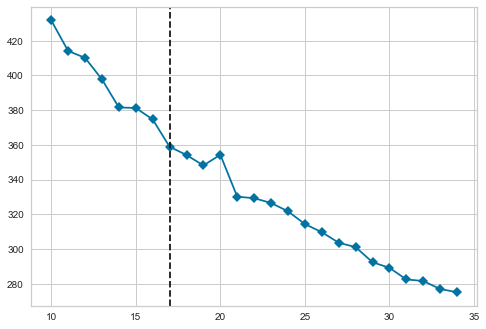

In [30]:
data_test_brick_novelty_ukwac_ewm_cosinedist_cluster = get_novelty_ukwac_ewm_cosinedist_cluster(data_official_brick, 'brick', stopwords_edited, ukwac_subtitles, True, False)
data_test_brick_novelty_ukwac_ewm_cosinedist_cluster

## Novelty Algo 6
### sem_space + local minima + cosine distance + clustering
### average responses cosine distance in the same cluster
### idea is that phrases with same alternate task will group
### variation in phrase in the same cluster will  be averaged out
### differs from algo 5, does local minima not ewm

In [31]:
# get df with results of the cosine distance from prompt using the elementwise multiplied vectors in the response
def get_novelty_ukwac_minimavec_cosinedist_cluster(df, prompt, stopwords_list, sem_space, remove_sw, join_list):
    # clean the responses
    novel_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    novel_rating_df = novel_rating_df[novel_rating_df.astype(str)['response_processed'] != '[]']
    cleaned_responses = novel_rating_df['response_processed'].tolist()
    novel_rating_df['response_processed_phrase'] = [' '.join(x) for x in cleaned_responses]
    # list to store cosine sims
    cosine_sim_list = []

    # implement algo
    # pass in clean responses
    for response in cleaned_responses:
        # add novelty rating to list 
        cosine_sim_list.append(get_minima_vector_cos_distance(prompt, response, sem_space))

    # add novelty rating list to dataframe
    novel_rating_df['minima_vector_cosine_dis'] = cosine_sim_list
        
    novel_rating_df['minima_vector_cosine_dis_clus_avg'] = get_clustered_novelty_score(novel_rating_df, 'minima_vector_cosine_dis')
    
    # new column with novelty rating
    return novel_rating_df

,id,rating,creativity,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_TASA_nf_m,SemDis_glove_nf_m,SemDis_MEAN,SemDis_factor,response_processed,response_processed_phrase,minima_vector_cosine_dis,minima_vector_cosine_dis_clus_avg
0,1094,1,1,build a structure,build structure,Brick,brick,1.04816,0.99066,1.03950,1.04503,1.11838,1.04835,0.09817,"[build, structure]",build structure,0.750990,0.702228
1,1094,3,2,throw and break a window,throw break window,Brick,brick,0.81308,0.96334,0.98875,0.95989,0.80060,0.90513,-0.00879,"[throw, break, window]",throw break window,0.809089,0.803547
2,1094,3,3,use as a stepping stool,use stepping stool,Brick,brick,0.95635,0.88973,0.93905,0.91332,0.81483,0.90266,-0.02285,"[stepping, stool]",stepping stool,0.835023,0.811505
3,1094,4,4,drop a brick over a small fire to snuff it out,drop brick small fire snuff,Brick,brick,0.66796,1.00688,1.05756,1.09136,1.21151,1.00705,0.06749,"[drop, brick, small, fire, snuff]",drop brick small fire snuff,0.910539,0.849366
4,1094,3,4,as a hammer,hammer,Brick,brick,0.72563,0.84975,0.79230,0.97131,0.89504,0.84681,-0.10577,[hammer],hammer,0.725632,0.850080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,1525,3,2,throw at things,throw things,Brick,brick,1.09473,0.96693,0.97362,1.03125,1.05812,1.02493,0.06653,[throw],throw,0.736422,0.767351
390,1525,3,3,use as a hammer,use hammer,Brick,brick,1.03817,0.95695,1.05443,0.99882,1.16780,1.04323,0.09794,[hammer],hammer,0.725632,0.850080
391,1525,2,2,use to prop up a table,use prop table,Brick,brick,0.93961,0.96968,0.93109,0.93978,0.98742,0.95352,0.00993,"[prop, table]",prop table,0.955514,0.936252
392,1525,2,2,use as a weight,use weight,Brick,brick,1.09550,0.94977,1.05847,0.96398,1.14299,1.04214,0.10030,[weight],weight,0.918658,0.850080


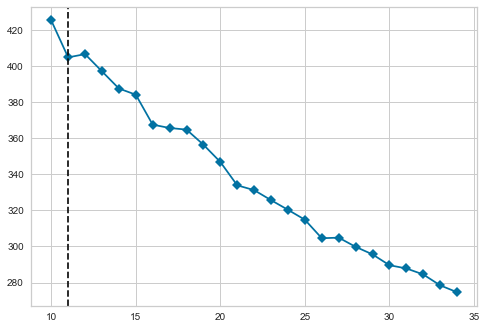

In [32]:
data_test_brick_novelty_ukwac_minimavec_cosinedist_cluster = get_novelty_ukwac_minimavec_cosinedist_cluster(data_official_brick, 'brick', stopwords_edited, ukwac_subtitles, True, False)
data_test_brick_novelty_ukwac_minimavec_cosinedist_cluster

### Write Results into Excel Sheet

In [33]:
prompts_list = ['box', 'brick', 'chair', 'cup', 'key', 'pencil', 'rope', 'shoe']
data_list = [data_official_box, data_official_brick, data_official_chair, data_official_cup, data_official_key, data_official_pencil, data_official_rope, data_official_shoe]
sem_space_list = [ukwac_subtitles, cbow_subtitles, banori, TASA, glove_6B]
sem_space_list_str = ['ukwac_subtitles', 'cbow_subtitles', 'banori', 'TASA', 'glove_6B']
sem_space_col_list = [7,8,9,10,11]

In [34]:
# write results df of each dataset for specific methods
def write_results_excel(method, stopwords, model):
    # change this when writing new sheet
    writer = pd.ExcelWriter('novelty_algo_6_results.xlsx', engine='xlsxwriter')

    for i in range(len(prompts_list)):
#         df = method(data_list[i], prompts_list[i], stopwords, model, True, False)
        df = method(data_list[i], prompts_list[i], stopwords, True, False)
        df.to_excel(writer, sheet_name = prompts_list[i], index = False)
    writer.save()

In [37]:
# write_results_excel(get_novelty_ukwac_ewm_cosinedist, stopwords_spacy, word_model_twitter25)

In [38]:
# write_results_excel(get_novelty_ukwac_minimavec_cosinedist, stopwords_spacy, word_model_twitter25)

In [39]:
# write_results_excel(get_novelty_ukwac_ewm_cosinedist_cluster, stopwords_spacy, word_model_twitter25)

In [40]:
# write_results_excel(get_novelty_ukwac_minimavec_cosinedist_cluster, stopwords_spacy, word_model_twitter25)

## Correlation Test with SemDis
### Comparing the Performance of the algos to SemDis

In [41]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [42]:
# print the correlations with SemDis
def print_corrs():
    for y in range(len(sem_space_list)):
        print(sem_space_list_str[y])
        for i in range(len(prompts_list)):
            print(prompts_list[i])
            ewm_df = get_novelty_ukwac_ewm_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_edited, sem_space_list[y], True, False)
            minima_df = get_novelty_ukwac_minimavec_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_edited, sem_space_list[y], True, False)       
            concat_df = pd.concat([ewm_df, minima_df.iloc[:, 16:]], axis=1)
            concat_df = concat_df.iloc[:, [sem_space_col_list[y],16,17,18,19]]
            pval_df = calculate_pvalues(concat_df)
            concat_df = concat_df.corr()
            corrs_df = pd.DataFrame(concat_df.iloc[1:, 0])
            pval_df = pd.DataFrame(pval_df.iloc[1:, 0])
            corr_pval_df = pd.concat([corrs_df, pval_df], axis=1)
            corr_pval_df.columns = [sem_space_list_str[y], 'pval']
            display(corr_pval_df)

ukwac_subtitles
box


,ukwac_subtitles,pval
ewm_vector_cosine_dis,0.628624,0.0
ewm_vector_cosine_dis_clus_avg,0.293926,0.0
minima_vector_cosine_dis,0.487944,0.0
minima_vector_cosine_dis_clus_avg,0.156037,0.001


brick


,ukwac_subtitles,pval
ewm_vector_cosine_dis,0.602996,0.0
ewm_vector_cosine_dis_clus_avg,0.396646,0.0
minima_vector_cosine_dis,0.431333,0.0
minima_vector_cosine_dis_clus_avg,0.285880,0.0


chair


,ukwac_subtitles,pval
ewm_vector_cosine_dis,0.827713,0.0
ewm_vector_cosine_dis_clus_avg,0.775545,0.0
minima_vector_cosine_dis,0.765201,0.0
minima_vector_cosine_dis_clus_avg,0.754592,0.0


cup


,ukwac_subtitles,pval
ewm_vector_cosine_dis,0.835245,0.0
ewm_vector_cosine_dis_clus_avg,0.714099,0.0
minima_vector_cosine_dis,0.688375,0.0
minima_vector_cosine_dis_clus_avg,0.616157,0.0


key


,ukwac_subtitles,pval
ewm_vector_cosine_dis,0.654186,0.0
ewm_vector_cosine_dis_clus_avg,0.286113,0.0
minima_vector_cosine_dis,0.285606,0.0
minima_vector_cosine_dis_clus_avg,0.123861,0.0156


pencil


,ukwac_subtitles,pval
ewm_vector_cosine_dis,0.796148,0.0
ewm_vector_cosine_dis_clus_avg,0.474320,0.0
minima_vector_cosine_dis,0.633005,0.0
minima_vector_cosine_dis_clus_avg,0.536072,0.0


rope


,ukwac_subtitles,pval
ewm_vector_cosine_dis,0.514802,0.0
ewm_vector_cosine_dis_clus_avg,0.150007,0.001
minima_vector_cosine_dis,0.275024,0.0
minima_vector_cosine_dis_clus_avg,0.017586,0.7013


shoe


,ukwac_subtitles,pval
ewm_vector_cosine_dis,0.648501,0.0
ewm_vector_cosine_dis_clus_avg,0.502671,0.0
minima_vector_cosine_dis,0.335716,0.0
minima_vector_cosine_dis_clus_avg,0.144050,0.0037


cbow_subtitles
box


,cbow_subtitles,pval
ewm_vector_cosine_dis,0.617730,0.0
ewm_vector_cosine_dis_clus_avg,0.359528,0.0
minima_vector_cosine_dis,0.502072,0.0
minima_vector_cosine_dis_clus_avg,0.048112,0.3134


brick


,cbow_subtitles,pval
ewm_vector_cosine_dis,0.760466,0.0
ewm_vector_cosine_dis_clus_avg,0.432506,0.0
minima_vector_cosine_dis,0.583408,0.0
minima_vector_cosine_dis_clus_avg,0.370595,0.0


chair


,cbow_subtitles,pval
ewm_vector_cosine_dis,0.892649,0.0
ewm_vector_cosine_dis_clus_avg,0.847626,0.0
minima_vector_cosine_dis,0.861011,0.0
minima_vector_cosine_dis_clus_avg,0.820802,0.0


cup


,cbow_subtitles,pval
ewm_vector_cosine_dis,0.818162,0.0
ewm_vector_cosine_dis_clus_avg,0.609113,0.0
minima_vector_cosine_dis,0.638400,0.0
minima_vector_cosine_dis_clus_avg,0.625217,0.0


key


,cbow_subtitles,pval
ewm_vector_cosine_dis,0.740503,0.0
ewm_vector_cosine_dis_clus_avg,0.273254,0.0
minima_vector_cosine_dis,0.320927,0.0
minima_vector_cosine_dis_clus_avg,0.142583,0.0053


pencil


,cbow_subtitles,pval
ewm_vector_cosine_dis,0.721980,0.0
ewm_vector_cosine_dis_clus_avg,0.595158,0.0
minima_vector_cosine_dis,0.633888,0.0
minima_vector_cosine_dis_clus_avg,0.628961,0.0


rope


,cbow_subtitles,pval
ewm_vector_cosine_dis,0.562246,0.0
ewm_vector_cosine_dis_clus_avg,0.241117,0.0
minima_vector_cosine_dis,0.417840,0.0
minima_vector_cosine_dis_clus_avg,0.192687,0.0


shoe


,cbow_subtitles,pval
ewm_vector_cosine_dis,0.721026,0.0
ewm_vector_cosine_dis_clus_avg,0.509370,0.0
minima_vector_cosine_dis,0.455136,0.0
minima_vector_cosine_dis_clus_avg,0.252595,0.0


banori
box


,banori,pval
ewm_vector_cosine_dis,0.698511,0.0
ewm_vector_cosine_dis_clus_avg,0.222082,0.0
minima_vector_cosine_dis,0.504538,0.0
minima_vector_cosine_dis_clus_avg,0.168821,0.0004


brick


,banori,pval
ewm_vector_cosine_dis,0.800546,0.0
ewm_vector_cosine_dis_clus_avg,0.500179,0.0
minima_vector_cosine_dis,0.673372,0.0
minima_vector_cosine_dis_clus_avg,0.302329,0.0


chair


,banori,pval
ewm_vector_cosine_dis,0.876424,0.0
ewm_vector_cosine_dis_clus_avg,0.798809,0.0
minima_vector_cosine_dis,0.832358,0.0
minima_vector_cosine_dis_clus_avg,0.774432,0.0


cup


,banori,pval
ewm_vector_cosine_dis,0.790208,0.0
ewm_vector_cosine_dis_clus_avg,0.454811,0.0
minima_vector_cosine_dis,0.599525,0.0
minima_vector_cosine_dis_clus_avg,0.468721,0.0


key


,banori,pval
ewm_vector_cosine_dis,0.532060,0.0
ewm_vector_cosine_dis_clus_avg,0.183750,0.0003
minima_vector_cosine_dis,0.088354,0.085
minima_vector_cosine_dis_clus_avg,-0.066909,0.1925


pencil


,banori,pval
ewm_vector_cosine_dis,0.750287,0.0
ewm_vector_cosine_dis_clus_avg,0.594360,0.0
minima_vector_cosine_dis,0.669895,0.0
minima_vector_cosine_dis_clus_avg,0.464796,0.0


rope


,banori,pval
ewm_vector_cosine_dis,0.681241,0.0
ewm_vector_cosine_dis_clus_avg,0.399972,0.0
minima_vector_cosine_dis,0.605779,0.0
minima_vector_cosine_dis_clus_avg,0.147815,0.0012


shoe


,banori,pval
ewm_vector_cosine_dis,0.800472,0.0
ewm_vector_cosine_dis_clus_avg,0.415308,0.0
minima_vector_cosine_dis,0.645295,0.0
minima_vector_cosine_dis_clus_avg,0.307535,0.0


TASA
box


,TASA,pval
ewm_vector_cosine_dis,0.610802,0.0
ewm_vector_cosine_dis_clus_avg,0.160649,0.0007
minima_vector_cosine_dis,0.541444,0.0
minima_vector_cosine_dis_clus_avg,0.157516,0.0009


brick


,TASA,pval
ewm_vector_cosine_dis,0.877071,0.0
ewm_vector_cosine_dis_clus_avg,0.627453,0.0
minima_vector_cosine_dis,0.782293,0.0
minima_vector_cosine_dis_clus_avg,0.289652,0.0


chair


,TASA,pval
ewm_vector_cosine_dis,0.928228,0.0
ewm_vector_cosine_dis_clus_avg,0.653560,0.0
minima_vector_cosine_dis,0.892954,0.0
minima_vector_cosine_dis_clus_avg,0.863964,0.0


cup


,TASA,pval
ewm_vector_cosine_dis,0.877639,0.0
ewm_vector_cosine_dis_clus_avg,0.381106,0.0
minima_vector_cosine_dis,0.725667,0.0
minima_vector_cosine_dis_clus_avg,0.587228,0.0


key


,TASA,pval
ewm_vector_cosine_dis,0.728262,0.0
ewm_vector_cosine_dis_clus_avg,0.271859,0.0
minima_vector_cosine_dis,0.376685,0.0
minima_vector_cosine_dis_clus_avg,0.056996,0.2671


pencil


,TASA,pval
ewm_vector_cosine_dis,0.874151,0.0
ewm_vector_cosine_dis_clus_avg,0.741743,0.0
minima_vector_cosine_dis,0.817355,0.0
minima_vector_cosine_dis_clus_avg,0.539228,0.0


rope


,TASA,pval
ewm_vector_cosine_dis,0.657921,0.0
ewm_vector_cosine_dis_clus_avg,0.356585,0.0
minima_vector_cosine_dis,0.490656,0.0
minima_vector_cosine_dis_clus_avg,0.320097,0.0


shoe


,TASA,pval
ewm_vector_cosine_dis,0.785925,0.0
ewm_vector_cosine_dis_clus_avg,0.586717,0.0
minima_vector_cosine_dis,0.566796,0.0
minima_vector_cosine_dis_clus_avg,0.062991,0.2064


glove_6B
box


,glove_6B,pval
ewm_vector_cosine_dis,0.355974,0.0
ewm_vector_cosine_dis_clus_avg,0.167790,0.0004
minima_vector_cosine_dis,0.199429,0.0
minima_vector_cosine_dis_clus_avg,0.035348,0.459


brick


,glove_6B,pval
ewm_vector_cosine_dis,0.664411,0.0
ewm_vector_cosine_dis_clus_avg,0.392655,0.0
minima_vector_cosine_dis,0.435784,0.0
minima_vector_cosine_dis_clus_avg,0.345002,0.0


chair


,glove_6B,pval
ewm_vector_cosine_dis,0.725254,0.0
ewm_vector_cosine_dis_clus_avg,0.701223,0.0
minima_vector_cosine_dis,0.662959,0.0
minima_vector_cosine_dis_clus_avg,0.628930,0.0


cup


,glove_6B,pval
ewm_vector_cosine_dis,0.559136,0.0
ewm_vector_cosine_dis_clus_avg,0.329192,0.0
minima_vector_cosine_dis,0.260218,0.0
minima_vector_cosine_dis_clus_avg,0.135234,0.0044


key


,glove_6B,pval
ewm_vector_cosine_dis,0.535779,0.0
ewm_vector_cosine_dis_clus_avg,0.204446,0.0001
minima_vector_cosine_dis,-0.213720,0.0
minima_vector_cosine_dis_clus_avg,-0.220647,0.0


pencil


,glove_6B,pval
ewm_vector_cosine_dis,0.723635,0.0
ewm_vector_cosine_dis_clus_avg,0.579421,0.0
minima_vector_cosine_dis,0.561862,0.0
minima_vector_cosine_dis_clus_avg,0.463633,0.0


rope


,glove_6B,pval
ewm_vector_cosine_dis,0.601145,0.0
ewm_vector_cosine_dis_clus_avg,0.234039,0.0
minima_vector_cosine_dis,0.411058,0.0
minima_vector_cosine_dis_clus_avg,0.024474,0.5935


shoe


,glove_6B,pval
ewm_vector_cosine_dis,0.694004,0.0
ewm_vector_cosine_dis_clus_avg,0.498183,0.0
minima_vector_cosine_dis,0.551488,0.0
minima_vector_cosine_dis_clus_avg,0.292324,0.0


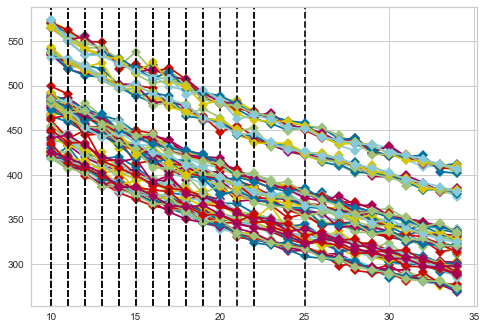

In [43]:
print_corrs()

In [44]:
def write_corrs():
    writer = pd.ExcelWriter('novelty_algos_semdis_corrs.xlsx', engine='xlsxwriter')
    workbook = writer.book

    for y in range(len(sem_space_list)):
        row = 0
        worksheet = workbook.add_worksheet(sem_space_list_str[y])
        writer.sheets[sem_space_list_str[y]] = worksheet
        for i in range(len(prompts_list)):
            worksheet.write_string(row, 0, prompts_list[i])
            ewm_df = get_novelty_ukwac_ewm_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_edited, sem_space_list[y], True, False)
            minima_df = get_novelty_ukwac_minimavec_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_edited, sem_space_list[y], True, False)       
            concat_df = pd.concat([ewm_df, minima_df.iloc[:, 16:]], axis=1)
            concat_df = concat_df.iloc[:, [sem_space_col_list[y],16,17,18,19]]
            pval_df = calculate_pvalues(concat_df)
            concat_df = concat_df.corr()
            corrs_df = pd.DataFrame(concat_df.iloc[1:, 0])
            pval_df = pd.DataFrame(pval_df.iloc[1:, 0])
            corr_pval_df = pd.concat([corrs_df, pval_df], axis=1)
            corr_pval_df.columns = [sem_space_list_str[y], 'pval']
            corr_pval_df.to_excel(writer, sheet_name = sem_space_list_str[y], startrow=row + 1, startcol=0, index = False)
            row = row + len(corr_pval_df.index) + 3
            
    writer.save()

In [48]:
# write_corrs()

## ICC Test 

,id,rating,creativity,response,response_nofill,item,item_nofill,SemDis_cbowukwacsubtitle_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_TASA_nf_m,SemDis_glove_nf_m,SemDis_MEAN,SemDis_factor,response_processed,response_processed_phrase,minima_vector_cosine_dis,minima_vector_cosine_dis_clus_avg
0,1159,1,1,wear on feet,wear feet,Shoe,shoe,1.14806,1.11889,0.99901,1.05112,1.00992,1.06540,0.14340,"[wear, foot]",wear foot,0.717765,0.742492
1,1159,3,3,to put stuff in,put stuff,Shoe,shoe,1.00684,0.99932,1.06153,0.88234,1.12912,1.01583,0.09572,[stuff],stuff,1.012120,0.979360
2,1159,1,1,to workout in,workout,Shoe,shoe,0.85628,0.81880,0.83366,0.96214,0.85576,0.86533,-0.11277,[workout],workout,0.962140,0.979360
3,1159,2,3,to use as a bug killer,use bug killer,Shoe,shoe,0.90506,0.98642,1.01619,0.93060,0.93217,0.95409,0.00311,"[bug, killer]",bug killer,1.055987,1.032459
4,1159,3,4,to use as a decoration,use decoration,Shoe,shoe,1.06171,0.92742,0.90422,1.07697,1.09134,1.01233,0.07513,[decoration],decoration,0.978774,0.978774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,1464,3,2,fashion,fashion,Shoe,shoe,0.70997,0.87638,0.73796,0.75035,0.68175,0.75128,-0.24414,[fashion],fashion,0.750349,0.979360
402,1464,3,2,throwing,throwing,Shoe,shoe,0.83038,0.88037,0.99284,1.00628,0.78348,0.89867,-0.08209,[throwing],throwing,1.006283,0.979360
403,1464,2,3,protection,protection,Shoe,shoe,0.95543,1.03424,1.04575,0.97823,0.93825,0.99038,0.04546,[protection],protection,0.978231,0.978231
404,1464,1,1,running,running,Shoe,shoe,0.78952,0.93675,0.88544,0.93103,0.83471,0.87549,-0.10120,[running],running,0.931030,0.931030


0.9509624790477333
0.9509624790477329


,prompt,method,rating
0,shoe,minima_vector_cosine_dis,0.950962
1,shoe,minima_vector_cosine_dis_clus_avg,0.950962


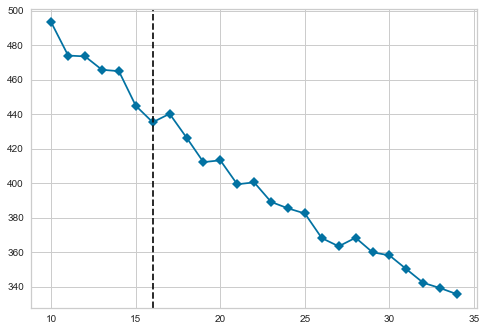

In [89]:
list_ratings = []
icc_test = get_novelty_ukwac_minimavec_cosinedist_cluster(data_official_shoe, 'shoe', stopwords_edited, TASA, True, False)
icc_test
display(icc_test)


avg1 = icc_test["minima_vector_cosine_dis"].mean()
print(avg1)
avg2 = icc_test["minima_vector_cosine_dis_clus_avg"].mean()
print(avg2)
inner_list1 = ['shoe', "minima_vector_cosine_dis", avg1]
inner_list2 = ['shoe', "minima_vector_cosine_dis_clus_avg", avg2]
list_ratings.append(inner_list1)
list_ratings.append(inner_list2)

test_df = pd.DataFrame(list_ratings, columns=['prompt', 'method', 'rating'])
test_df

#16, 17

In [87]:
def icc_calc_all_semspace_df():
    icc_list = []
    for y in range(len(sem_space_list)):
        for i in range(len(prompts_list)):
            ewm_df = get_novelty_ukwac_ewm_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_edited, sem_space_list[y], True, False)
            minima_df = get_novelty_ukwac_minimavec_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_edited, sem_space_list[y], True, False)    
            avg_ewm = ewm_df["ewm_vector_cosine_dis"].mean()
            list_ewm = [prompts_list[i], "ewm_vector_cosine_dis " + sem_space_list_str[y], avg_ewm]
            icc_list.append(list_ewm)
            avg_ewm_clust = ewm_df["ewm_vector_cosine_dis"].mean()
            list_ewm_clust = [prompts_list[i], "ewm_vector_cosine_dis_clus " + sem_space_list_str[y], avg_ewm_clust]
            icc_list.append(list_ewm_clust)
            avg_minima = minima_df["minima_vector_cosine_dis"].mean()
            list_minima = [prompts_list[i], "minima_vector_cosine_dis " + sem_space_list_str[y], avg_minima]
            icc_list.append(list_minima)
            avg_minima_clust = minima_df["minima_vector_cosine_dis_clus_avg"].mean()
            list_minima_clust = [prompts_list[i], "minima_vector_cosine_dis_clus_avg " + sem_space_list_str[y], avg_minima_clust]
            icc_list.append(list_minima_clust)
            
    icc_df = pd.DataFrame(icc_list, columns=['prompt', 'method', 'rating'])
    
    return icc_df

In [88]:
def icc_calc_one_semspace_df(sem_space):
    icc_list = []
    for i in range(len(prompts_list)):
        print(prompts_list[i])
        ewm_df = get_novelty_ukwac_ewm_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_edited, sem_space, True, False)
        minima_df = get_novelty_ukwac_minimavec_cosinedist_cluster(data_list[i], prompts_list[i], stopwords_edited, sem_space, True, False)    
        avg_ewm = ewm_df["ewm_vector_cosine_dis"].mean()
        list_ewm = [prompts_list[i], "ewm_vector_cosine_dis", avg_ewm]
        icc_list.append(list_ewm)
        avg_ewm_clust = ewm_df["ewm_vector_cosine_dis"].mean()
        list_ewm_clust = [prompts_list[i], "ewm_vector_cosine_dis_clus", avg_ewm_clust]
        icc_list.append(list_ewm_clust)
        avg_minima = minima_df["minima_vector_cosine_dis"].mean()
        list_minima = [prompts_list[i], "minima_vector_cosine_dis", avg_minima]
        icc_list.append(list_minima)
        avg_minima_clust = minima_df["minima_vector_cosine_dis_clus_avg"].mean()
        list_minima_clust = [prompts_list[i], "minima_vector_cosine_dis_clus_avg", avg_minima_clust]
        icc_list.append(list_minima_clust)
        
    icc_df = pd.DataFrame(icc_list, columns=['prompt', 'method', 'rating'])
    
    return icc_df

In [90]:
# icc_df_allsemspace = icc_calc_all_semspace_df()
# icc_df_allsemspace

box
brick
chair
cup
key
pencil
rope
shoe


,prompt,method,rating
0,box,ewm_vector_cosine_dis,0.867404
1,box,ewm_vector_cosine_dis_clus,0.867404
2,box,minima_vector_cosine_dis,0.806701
3,box,minima_vector_cosine_dis_clus_avg,0.806701
4,brick,ewm_vector_cosine_dis,0.877181
5,brick,ewm_vector_cosine_dis_clus,0.877181
6,brick,minima_vector_cosine_dis,0.803458
7,brick,minima_vector_cosine_dis_clus_avg,0.803458
8,chair,ewm_vector_cosine_dis,0.799870
9,chair,ewm_vector_cosine_dis_clus,0.799870


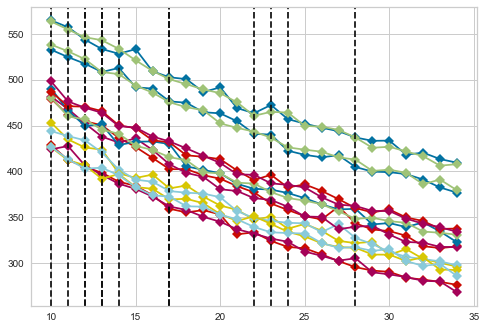

In [91]:
icc_df_ukwac_subtitles = icc_calc_one_semspace_df(ukwac_subtitles)
icc_df_ukwac_subtitles

In [92]:
icc_results = pg.intraclass_corr(data=icc_df_ukwac_subtitles, targets='prompt', raters='method', ratings='rating')

icc_results.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.476033,4.634064,7,24,2.125258e-03,"[0.13, 0.83]"
ICC2,Single random raters,0.533335,74.013767,7,21,2.283875e-13,"[0.08, 0.87]"
ICC3,Single fixed raters,0.948061,74.013767,7,21,2.283875e-13,"[0.86, 0.99]"
ICC1k,Average raters absolute,0.784207,4.634064,7,24,2.125258e-03,"[0.38, 0.95]"
ICC2k,Average random raters,0.820514,74.013767,7,21,2.283875e-13,"[0.26, 0.96]"
ICC3k,Average fixed raters,0.986489,74.013767,7,21,2.283875e-13,"[0.96, 1.0]"


Algo Design Brainstorming:
* Word2vec, average similarity between words in two responses
* Problems:
    * phrases vs words
    * compare between just two responses or the whole list of responses
* Algo Idea
    * find similarity between prompt and average of word in response
    * the average is the value that represents novelty
* Things to Look Into:
    * doc2Vec - look into sentence vector
        * follow similar logic to above but no need to average for multiple words
    * Word2Vec + SIF + Cosine Similarity
    * Word2Vec + WMD 
* Course of Actions for Missing Words/Misspellings?
    * hand remove?
* What to do when whole phrase stop words
    * make 0

To Do List
- [x] write preprocessing methods
- [x] write out initial algo
- [x] implement first algo idea
- [x] set up work environment on macbook
- [x] look into Word2Vec + SIF + Cosine Similarity
- [x] set up excel sheet download with different sheets
- [x] use ukwac semantic space for cosine distance
- [x] set up element wise multiplied vectors for cosine distance algo
- [x] set up phrase minima vector for cosine distance algo 
- [x] Compare the ewm and phrase minima algos with SemDis
- [x] Get a sense of the effect of the compositions
- [x] 1 - to get the distance
- [x] Remove the word could 
    - had to lowercase first and then remove stop words
- [x] write clustering method
    - count vectorizer and kmeans
- [x] update clustering method to use cosine distance not euclidean 
    - changed from scikit learn to cosine distance from NLTK 
- [x] write algo to average novelty scores of responses in the same category
    - do for both ewm and minima
- [x] use the elbow method to figure out how many clusters to use
- [x] download and upload all the semantic spaces from SemDis
- [x] update methods to change semantic spaces
- [x] copy semantic spaces to mac
- [x] set up scripts to pass in official data for pc and mac
- [x] add .DS_Store to gitignore
- [x] get SemDis results for all 6 different semantic spaces with the official data
- [x] compare performance on the 6 different semantic spaces
    - correlation tests for coefficient and significance
- [x] update stop words list to include "use" and "thing"
- [ ] figure out how many times to run kmeans
    - cross validation
    - then averaging the results of all the iterations
- [ ] figure out way to automate the number of clusters used in each run
 
Don't look into unless you have time
- [ ] look into doc2vec 
- [ ] look into Word2Vec + WMD 
- [ ] look at https://github.com/PrincetonML/SIF for better SIF 
